ML Final Project
Updated Modeling Efforts, per Arnab's insight

Mark Roberts

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler

### Modeling Overview:

#### Models to be used:
 1. Logistic Regression
 
 2. Random Forest
 
 3. AdaBoost
 
 4. Gradient Boost
 
 
 
#### Methodology:   
    1. Raw data (no undersampling). For each model:
         - Grid search for optimal parameters
         - Optimize prediction probability threshold
         - Create ensemble model combining all 4 models' predictions
                
    2. Balanced Data (Random undersampling with .5/.5 split). For each model:
        - Grid search for optimal parameters
        - Optimize prediction probability threshold
        - Create ensemble model combining all 4 models' predictions
            
    3. Choose best method
        - Required metrics for target variable:
            1. Maximize Recall
            2. Precision >.10
            
                
    

# Data Import

In [24]:
#importing data
dat = pd.read_csv('dat_fe.csv', index_col = "Unnamed: 0")

/Users/markroberts/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/markroberts/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [25]:
#creating target variable
dat['target'] = [0 if pd.isna(x) else 1 for x in dat['EVENT_TYPE']] 

In [26]:
#dropping cheat variables
dat = dat.drop(['EVENT_TYPE','INJURIES_DIRECT', 'INJURIES_INDIRECT',
                'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 
                'DAMAGE_CROPS'], axis=1)

In [27]:
#dropping NA's
dat= dat.dropna(axis=0)
dat.shape

(3772954, 37)

In [28]:
#splitting into X,y
X = dat.drop('target', axis=1)
y = dat['target']

### Train/Test Split- no balancing

In [29]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Train/Test Split- under sampling

In [30]:
#random undersampling defaults to .50/.50 split of minority class for train data
rus = RandomUnderSampler(random_state=1)
rus.fit(X, y)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

### Scaling X_train, X_test

In [31]:
#scaling data
scaler = StandardScaler()

# fitting scaler to training data
scaler = scaler.fit(X_train)

# scaling training data using training parameters
X_train_scaled = scaler.transform(X_train)

# scaling test data using tranining parameters
X_test_scaled = scaler.transform(X_test)

### Scaling undersampled data: Train only

In [135]:
#scaling data
scaler_rus = StandardScaler()

# fitting scaler to training data
scaler_rus = scaler_rus.fit(X_train_rus)

# scaling training data using training parameters
X_train_rus_scaled = scaler_rus.transform(X_train_rus)

# Logistic Regression Grid Search

In [254]:
#creating paramater grid
param_grid_logreg = {
    'C':np.arange(.01, 2.02,.3).tolist(),
    'random_state': [1],
    'max_iter': [1000]
}

#creating logistic regression object
logreg_clf = LogisticRegression(random_state=1)

#initializing grid search object 
GS_logreg_grid = GridSearchCV(logreg_clf, param_grid_logreg, cv=5, verbose=5, n_jobs=-1, scoring = 'roc_auc')

#fitting gridsearch on train data
GS_logreg_res = GS_logreg_grid.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:  3.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:  5.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.6min finished


In [255]:
#fitting new model name to the best estimator
logreg_GS_best = GS_logreg_res.best_estimator_

#saving model with pickle
import pickle
filename = 'logreg_GS_best_model.sav'
pickle.dump(logreg_GS_best, open(filename, 'wb'))

# load the model from disk
logreg_res = pickle.load(open('logreg_GS_best_model.sav', 'rb'))

In [256]:
#making predictions on test data
GS_logreg_test_pred = logreg_res.predict(X_test_scaled)

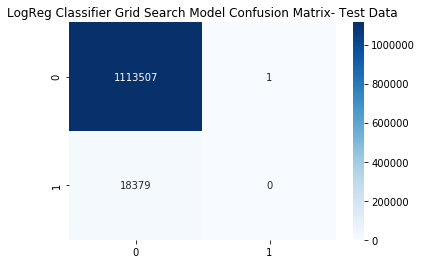

In [257]:
# Test data Confusion Matrix
cm = confusion_matrix(y_test, GS_logreg_test_pred)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'LogReg Classifier Grid Search Model Confusion Matrix- Test Data')
plt.show()

In [258]:
# test data classification report
print("GS logreg on Test Data Classification Report:")
print(classification_report(y_test, GS_logreg_test_pred, zero_division=0))

GS logreg on Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1113508
           1       0.00      0.00      0.00     18379

    accuracy                           0.98   1131887
   macro avg       0.49      0.50      0.50   1131887
weighted avg       0.97      0.98      0.98   1131887



In [259]:
#making predictions on training data
logreg_GS_train_pred = logreg_res.predict(X_train_scaled)

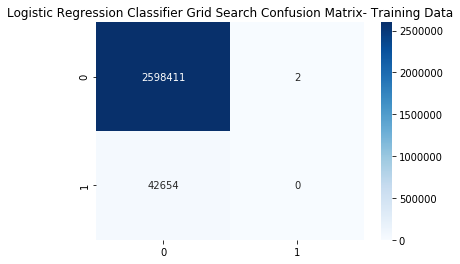

In [260]:
# Training data Confusion Matrix
cm = confusion_matrix(y_train, logreg_GS_train_pred)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'Logistic Regression Classifier Grid Search Confusion Matrix- Training Data')
plt.show()

In [262]:
# training data classification report
print("Logistic Regression Classifier GS Model on Training Data Classification Report:")
print(classification_report(y_train, logreg_GS_train_pred, zero_division=0))

Logistic Regression Classifier GS Model on Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   2598413
           1       0.00      0.00      0.00     42654

    accuracy                           0.98   2641067
   macro avg       0.49      0.50      0.50   2641067
weighted avg       0.97      0.98      0.98   2641067



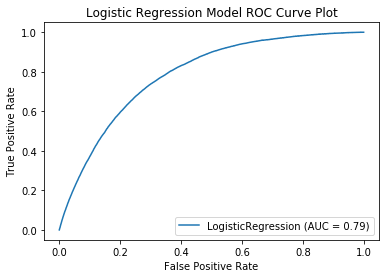

In [263]:
#Plotting AUC curve 
RF_disp = plot_roc_curve(logreg_res, X_test_scaled, y_test)
plt.title("Logistic Regression Model ROC Curve Plot")
plt.show()

### Optimizing prediction threshold- Logistic Regression

In [41]:
#grabbing prediction probabilities
logreg_prediction_probs = logreg_res.predict_proba(X_test_scaled)[:,1]

In [42]:
#looping through threshold levels for precision, recall, accuracy scores
thresh=np.arange(.05,1,.05) #.05 to 1 by .05
logreg_lst_recall = []
logreg_lst_precision =[]
logreg_lst_accuracy = []

for i in thresh:
    preds = [1 if x==True else 0 for x in logreg_prediction_probs > i] #logistic regression prediction probs
    report = classification_report(y_test, preds, zero_division=0, output_dict=True)
    logreg_lst_recall.append(report['1']['recall'])
    logreg_lst_precision.append(report['1']['precision'])
    logreg_lst_accuracy.append(report['accuracy'])

In [43]:
df_logreg = pd.DataFrame([logreg_lst_recall, logreg_lst_precision, logreg_lst_accuracy,thresh], 
                     index=["Recall", "Precision","Accuracy","Threshold"]).T
df_logreg

,Recall,Precision,Accuracy,Threshold
0,0.235867,0.065340,0.932808,0.05
1,0.029381,0.083090,0.978975,0.10
2,0.003972,0.082393,0.983109,0.15
3,0.000544,0.056497,0.983624,0.20
4,0.000163,0.050000,0.983715,0.25
5,0.000054,0.038462,0.983741,0.30
6,0.000000,0.000000,0.983752,0.35
7,0.000000,0.000000,0.983757,0.40
8,0.000000,0.000000,0.983760,0.45
9,0.000000,0.000000,0.983762,0.50


In [404]:
#melting recall, precision
df_logreg_ploting = df_logreg.melt(id_vars =['Threshold'], value_vars =['Recall', 'Precision'])
df_logreg_ploting['Threshold'] = round(df_logreg_ploting['Threshold'],2)
#df_logreg_ploting.head(10)

#melting accuracy
df_logreg_ploting2 = df_logreg.melt(id_vars =['Threshold'], value_vars =['Accuracy'])
df_logreg_ploting2['Threshold'] = round(df_logreg_ploting2['Threshold'],2)
#df_logreg_ploting2.head(10)

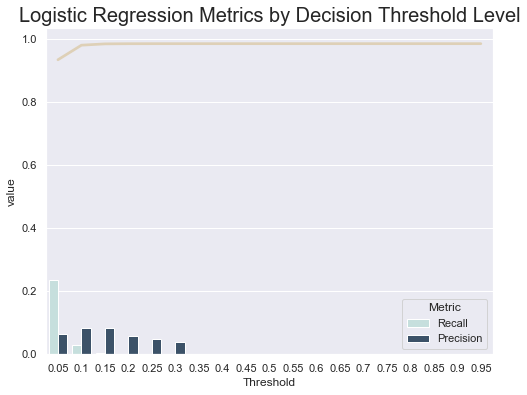

In [461]:
#best plot yet

labels = ['Recall', 'Precision', "Accuracy"]


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.barplot(x="Threshold", y="value", hue="variable", data=df_logreg_ploting, palette="ch:2.9,-.2,dark=.3")
sns.pointplot(x='Threshold', y='value', data=df_logreg_ploting2,ax=ax,color="#ded0b7", markers = "")
plt.title("Logistic Regression Metrics by Decision Threshold Level",fontsize=20)

h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="Metric")

plt.show()

### Logistic Regression never reached acceptable precision, recall levels





In [330]:
#saving optimized (best) predictions
logreg_preds_opt = [1 if x==True else 0 for x in logreg_res.predict_proba(X_test_scaled)[:,1] >= .05]
logreg_preds_opt[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Random Forest 

In [46]:
#creating model object
RF_clf = RandomForestClassifier(random_state=1, verbose=5, n_jobs=-1)

#creating paramater grid
param_grid_RF = {
    'n_estimators':np.arange(50, 150,10).tolist(),
    'random_state': [1],
    'max_depth': np.arange(4,15,3).tolist()
 }

#creating gridseatrc
GS_RF_grid = GridSearchCV(RF_clf, param_grid_RF, cv=5, verbose=1, n_jobs=-1, scoring = 'roc_auc')

#fitting gridsearch on train data
GS_RF_res = GS_RF_grid.fit(X_train,y_train)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Users/markroberts/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 410.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 493.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140building tree 8 of 140

building tree 9 of 140building tree 10 of 140building tree 11 of 140

building tree 12 of 140

building tree 13 of 140
building tree 14 of 140
building tree 15 of 140building tree 16 of 140

building tree 17 of 140building tree 18 of 140

building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140
building tree 40 of 140
building tree 41 of 140
building tree 42 of 140
b

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.3min


building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81 of 140
building tree 82 of 140
building tree 83 of 140
building tree 84 of 140
building tree 85 of 140
building tree 86 of 140
building tree 87 of 140
building tree 88 of 140
building tree 89 of 140
building tree 90 of 140
building tree 91 of 140
building tree 92 of 140
building tree 93 of 140
building tree 94 of 140
building tree 95 of 140
building tree 96 of 140
building tree 97 of 140
building tree 98 of 140
building tree 99 of 140
building tree 100 of 140
building tree 1

[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  6.6min finished


In [47]:
#fitting new model to the best estimator with best parameters
RF_GS_best = GS_RF_res.best_estimator_
RF_GS_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=140,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=5,
                       warm_start=False)

In [48]:
#saving model
import pickle
filename = 'RF_GS_best_model.sav'
pickle.dump(RF_GS_best, open(filename, 'wb'))

# load the model from disk
RF_GS_best = pickle.load(open('RF_GS_best_model.sav', 'rb'))

In [49]:
#making test predictions using test data
GS_RF_test_pred = RF_GS_best.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    3.6s finished


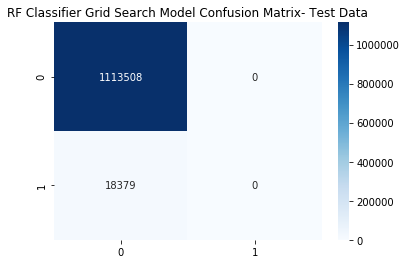

In [50]:
# Test data Confusion Matrix
cm = confusion_matrix(y_test, GS_RF_test_pred)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'RF Classifier Grid Search Model Confusion Matrix- Test Data')
plt.show()

In [51]:
# test data classification report
print("GS RF Classifier#1 on Test Data Classification Report:")
print(classification_report(y_test, GS_RF_test_pred, zero_division=0))

GS RF Classifier#1 on Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1113508
           1       0.00      0.00      0.00     18379

    accuracy                           0.98   1131887
   macro avg       0.49      0.50      0.50   1131887
weighted avg       0.97      0.98      0.98   1131887



#### Checking training data performance

In [52]:
#making predictions on training data
RF_train_pred = RF_GS_best.predict(X_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    2.9s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    8.4s finished


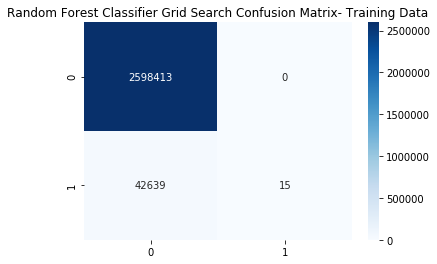

In [53]:
# Train data Confusion Matrix
cm = confusion_matrix(y_train, RF_train_pred)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'Random Forest Classifier Grid Search Confusion Matrix- Training Data')
plt.show()

In [54]:
# train data classification report
print("Random Forest Classifier Grid Search on Train Data Classification Report:")
print(classification_report(y_train, RF_train_pred, zero_division=0))

Random Forest Classifier Grid Search on Train Data Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   2598413
           1       1.00      0.00      0.00     42654

    accuracy                           0.98   2641067
   macro avg       0.99      0.50      0.50   2641067
weighted avg       0.98      0.98      0.98   2641067



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    3.3s finished


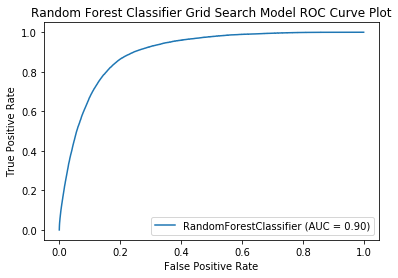

In [55]:
#Plotting AUC 
RF_disp = plot_roc_curve(RF_GS_best, X_test, y_test)
plt.title("Random Forest Classifier Grid Search Model ROC Curve Plot")
plt.show()

### Optimizing prediction threshold-Random Forest

In [56]:
#grabbing prediction probabilities
RF_prediction_probs = RF_GS_best.predict_proba(X_test)[:,1]

#looping through threshold levels for precision, recall, accuracy scores
thresh=np.arange(.05,1,.05)
RF_lst_recall = []
RF_lst_precision =[]
RF_lst_accuracy = []

for i in thresh:
    preds = [1 if x==True else 0 for x in RF_prediction_probs > i] #Random Forest prediction probs
    report = classification_report(y_test, preds, zero_division=0, output_dict=True)
    RF_lst_recall.append(report['1']['recall'])
    RF_lst_precision.append(report['1']['precision'])
    RF_lst_accuracy.append(report['accuracy'])
    

df_RF = pd.DataFrame([RF_lst_recall, RF_lst_precision, RF_lst_accuracy,thresh], 
                     index=["Recall", "Precision","Accuracy","Threshold"]).T
df_RF


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    3.3s finished


,Recall,Precision,Accuracy,Threshold
0,0.634093,0.104552,0.905877,0.05
1,0.066217,0.270806,0.981943,0.10
2,0.009685,0.542683,0.983787,0.15
3,0.002938,0.562500,0.983773,0.20
4,0.001578,0.725000,0.983778,0.25
5,0.000435,0.615385,0.983765,0.30
6,0.000218,0.666667,0.983764,0.35
7,0.000054,1.000000,0.983763,0.40
8,0.000000,0.000000,0.983763,0.45
9,0.000000,0.000000,0.983763,0.50


In [476]:
#melting recall, precision, accuracy
df_RF_tableau = df_RF.melt(id_vars =['Threshold'], value_vars =['Recall', 'Precision', 'Accuracy'])
df_RF_tableau['Threshold'] = round(df_RF_tableau['Threshold'],2)

df_RF_tableau.to_csv("RF_melted.csv")

In [471]:
import os
os. getcwd()

'/Users/markroberts/Desktop/Machine Learning/FinalProject'

In [411]:
#melting recall, precision
df_RF_ploting = df_RF.melt(id_vars =['Threshold'], value_vars =['Recall', 'Precision'])
df_RF_ploting['Threshold'] = round(df_RF_ploting['Threshold'],2)
#df_RF_ploting.head(10)

#melting accuracy
df_RF_ploting2 = df_RF.melt(id_vars =['Threshold'], value_vars =['Accuracy'])
df_RF_ploting2['Threshold'] = round(df_RF_ploting2['Threshold'],2)
#df_RF_ploting2.head(10)

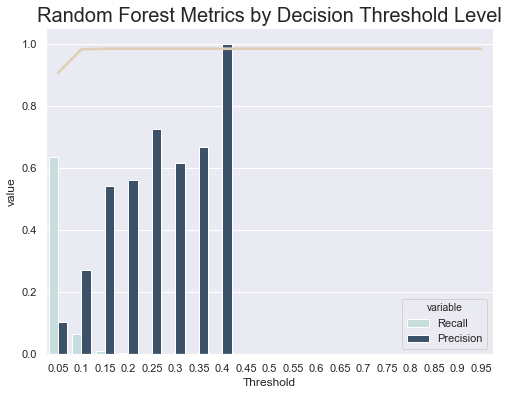

In [463]:
#best plot yet
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.barplot(x="Threshold", y="value", hue="variable", data=df_RF_ploting, palette="ch:2.9,-.2,dark=.3")
sns.pointplot(x='Threshold', y='value', data=df_RF_ploting2,ax=ax,color='#ded0b7', markers = "")
plt.title("Random Forest Metrics by Decision Threshold Level", fontsize=20)
plt.show()

In [58]:
# Feature importances
#grabbing top features in a  pandas dataframe
feature_importances_RF = pd.DataFrame(RF_GS_best.feature_importances_,
                                   index = X_train.columns,
                                    columns=['Importance']).sort_values('Importance',ascending=False)

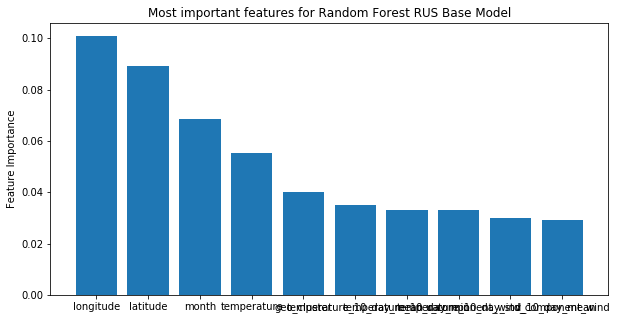

In [59]:
#plotting top 10 feature importance
fig=plt.figure(figsize=(10, 5))
plt.bar(feature_importances_RF.index[:10], feature_importances_RF['Importance'][:10])
plt.title("Most important features for Random Forest RUS Base Model")
plt.ylabel("Feature Importance")
plt.show()

# Best RF Model threshold

In [109]:
#saving optimized predictions
RF_preds_opt = [1 if x==True else 0 for x in RF_GS_best.predict_proba(X_test_scaled)[:,1] >= .1]
RF_preds_opt[:10]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 140 out of 140 | elapsed:    1.7s finished


[1, 0, 0, 1, 0, 1, 0, 0, 0, 0]

# ADAboost

In [60]:
#initilizing
ABC_GS = AdaBoostClassifier()

#creating paramater grid
param_grid_ab = {
    'n_estimators':np.arange(50, 110, 20).tolist(),
    'learning_rate': [.1,.5,1,2],
    'random_state': [1]
 }

#initializing grid search object 
GS_ab_1 = GridSearchCV(ABC_GS,param_grid_ab, cv=5, verbose=1, n_jobs=-1, scoring = 'roc_auc')

#fitting gridsearch on train data
GS_ab_1 = GS_ab_1.fit(X_train_scaled,y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Users/markroberts/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 74.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 142.2min finished


In [61]:
#grabbing best estimator
GS_ab_best = GS_ab_1.best_estimator_
GS_ab_best

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=90, random_state=1)

In [62]:
#saving model
import pickle
filename = 'GS_ab_best_model.sav'
pickle.dump(GS_ab_best, open(filename, 'wb'))

# load the model from disk
GS_ab_best = pickle.load(open('GS_ab_best_model.sav', 'rb'))

In [63]:
#making test predictions
GS_ab_best_test_pred = GS_ab_best.predict(X_test_scaled)


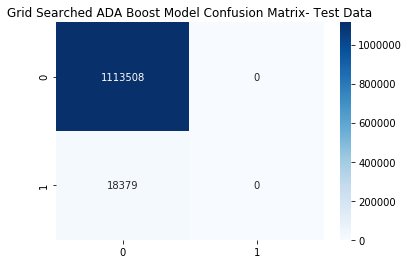

In [64]:
# Test data Confusion Matrix
cm = confusion_matrix(y_test,GS_ab_best_test_pred )

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'Grid Searched ADA Boost Model Confusion Matrix- Test Data')
plt.show()

In [65]:
# test data classification report
print('Grid Searched ADA Boost Model Confusion Matrix- Test Data')
print(classification_report(y_test,GS_ab_best_test_pred , zero_division=0))

Grid Searched ADA Boost Model Confusion Matrix- Test Data
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1113508
           1       0.00      0.00      0.00     18379

    accuracy                           0.98   1131887
   macro avg       0.49      0.50      0.50   1131887
weighted avg       0.97      0.98      0.98   1131887



In [66]:
#making predictions on training data
GS_ab_best_train_pred = GS_ab_best.predict(X_train_scaled)

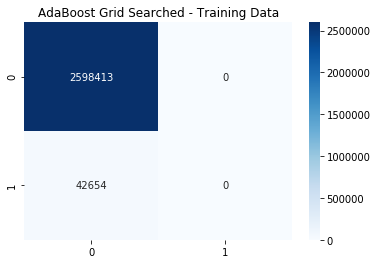

In [67]:
# Training data Confusion Matrix
cm = confusion_matrix(y_train,GS_ab_best_train_pred)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'AdaBoost Grid Searched - Training Data')
plt.show()

In [68]:
# training data classification report
print("AdaBoost1- Training Data Classification Report:")
print(classification_report(y_train, GS_ab_best_train_pred, zero_division=0))

AdaBoost1- Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   2598413
           1       0.00      0.00      0.00     42654

    accuracy                           0.98   2641067
   macro avg       0.49      0.50      0.50   2641067
weighted avg       0.97      0.98      0.98   2641067



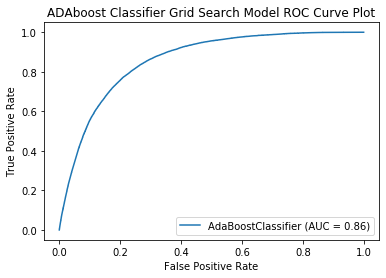

In [69]:
#Plotting AUC 
AB_disp = plot_roc_curve(GS_ab_best, X_test_scaled, y_test)
plt.title("ADAboost Classifier Grid Search Model ROC Curve Plot")
plt.show()

In [72]:
#grabbing top features in a  pandas dataframe
feature_importances_AB = pd.DataFrame(GS_ab_best.feature_importances_,
                                   index = X_train.columns,
                                    columns=['Importance']).sort_values('Importance',ascending=False)

#printing out top 20 most important features from newly created dataframe
feature_importances_AB.sort_values(by=['Importance'], ascending=False)[:20]

,Importance
longitude,0.233333
latitude,0.177778
month,0.100000
v_component_wind,0.077778
temperature,0.066667
relative_humidity,0.033333
u_component_wind,0.033333
temperature_10_day_std,0.033333
vertical_velocity_10_day_std,0.022222
v_component_wind_10_day_mean,0.022222


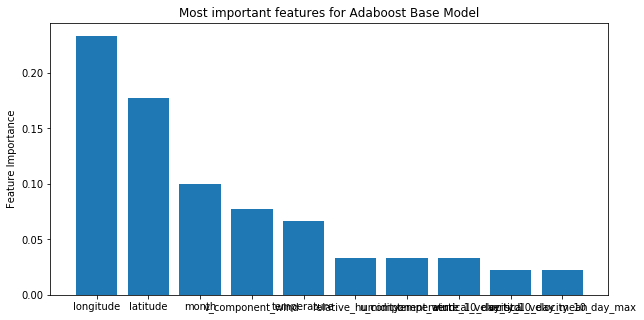

In [73]:
#plotting top 10 feature importance
fig=plt.figure(figsize=(10, 5))
plt.bar(feature_importances_AB.index[:10], feature_importances_AB['Importance'][:10])
plt.title("Most important features for Adaboost Base Model")
plt.ylabel("Feature Importance")
plt.show()

In [344]:
#grabbing prediction probabilities
AB_prediction_probs = GS_ab_best.predict_proba(X_test_scaled)[:,1]

#looping through threshold levels for precision, recall, accuracy scores
thresh=np.arange(.05,1,.05)
AB_lst_recall = []
AB_lst_precision =[]
AB_lst_accuracy = []

for i in thresh:
    preds = [1 if x==True else 0 for x in AB_prediction_probs > i] #ADAboost prediction probs
    report = classification_report(y_test, preds, zero_division=0, output_dict=True)
    AB_lst_recall.append(report['1']['recall'])
    AB_lst_precision.append(report['1']['precision'])
    AB_lst_accuracy.append(report['accuracy'])
    

df_AB = pd.DataFrame([AB_lst_recall, AB_lst_precision, AB_lst_accuracy,thresh], 
                     index=["Recall", "Precision","Accuracy","Threshold"]).T
df_AB

,Recall,Precision,Accuracy,Threshold
0,1.000000,0.016237,0.016237,0.05
1,1.000000,0.016237,0.016237,0.10
2,1.000000,0.016237,0.016237,0.15
3,1.000000,0.016237,0.016237,0.20
4,1.000000,0.016237,0.016237,0.25
5,1.000000,0.016237,0.016237,0.30
6,1.000000,0.016259,0.017586,0.35
7,0.999946,0.016342,0.022682,0.40
8,0.999891,0.016706,0.044391,0.45
9,0.000000,0.000000,0.983763,0.50


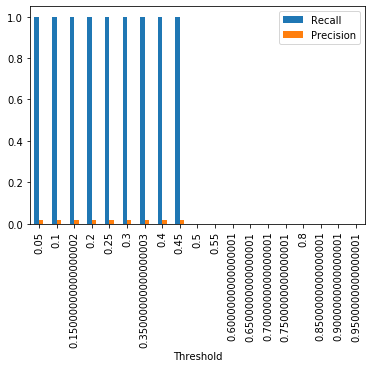

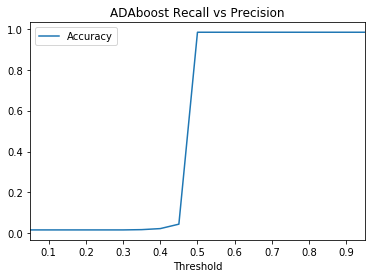

In [345]:
#plotting
df_AB.plot(x=3, y=[0,1], kind='bar')
df_AB.plot(x=3, y=2, kind='line')
plt.title("ADAboost Recall vs Precision")
plt.show()

In [361]:
#melting recall, precision
df_AB_ploting = df_AB.melt(id_vars =['Threshold'], value_vars =['Recall', 'Precision'])
df_AB_ploting['Threshold'] = round(df_AB_ploting['Threshold'],2)
#df_AB_ploting.head(10)

#melting accuracy
df_AB_ploting2 = df_AB.melt(id_vars =['Threshold'], value_vars =['Accuracy'])
df_AB_ploting2['Threshold'] = round(df_AB_ploting2['Threshold'],2)
#df_AB_ploting2.head(10)

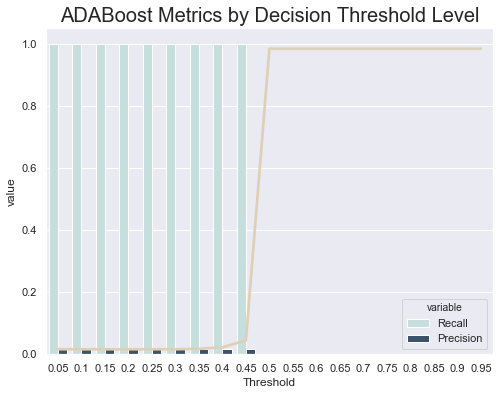

In [466]:
#best plot yet
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.barplot(x="Threshold", y="value", hue="variable", data=df_AB_ploting, palette="ch:2.9,-.2,dark=.3")
sns.pointplot(x='Threshold', y='value', data=df_AB_ploting2,ax=ax, color='#ded0b7', markers = "")
plt.title("ADABoost Metrics by Decision Threshold Level", fontsize=20)
plt.show()

# Insert Best ADABoost model here:

In [112]:
#saving optimized predictions
ab_preds_opt = [1 if x==True else 0 for x in GS_ab_best.predict_proba(X_test_scaled)[:,1] >= .47] #halfway between .45 and .5
ab_preds_opt[:10]

[1, 0, 1, 0, 0, 0, 1, 1, 1, 0]

# Gradient Boost

In [87]:
# Initializing object
GB_GS = GradientBoostingClassifier()

#creating paramater grid
param_grid_gb = {
    'n_estimators':np.arange(50, 110, 20).tolist(),
    'learning_rate': [.1,.5,1,2],
    'random_state': [1]
 }

#initializing grid search object 
GS_gb_1 = GridSearchCV(GB_GS,param_grid_ab, cv=5, verbose=1, n_jobs=-1, scoring = 'roc_auc')

#fitting gridsearch on train data
GS_gb_1 = GS_gb_1.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Users/markroberts/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 157.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 300.5min finished


In [88]:
#best estimator
GS_gb_best = GS_gb_1.best_estimator_
GS_gb_best

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=90,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [89]:
#saving model
import pickle
filename = 'GS_gb_best_model.sav'
pickle.dump(GS_gb_best, open(filename, 'wb'))

# load the model from disk
GS_gb_best = pickle.load(open('GS_gb_best_model.sav', 'rb'))

In [90]:
#test predictions
GS_gb_best_test_pred = GS_gb_best.predict(X_test_scaled)

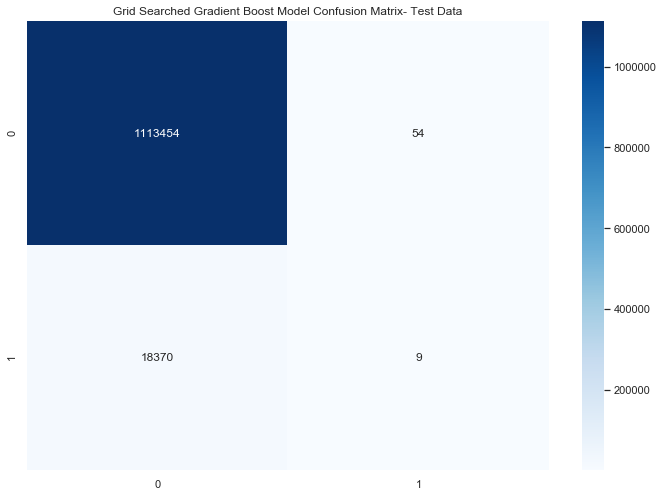

In [468]:
# Test data Confusion Matrix
cm = confusion_matrix(y_test,GS_gb_best_test_pred )

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'Grid Searched Gradient Boost Model Confusion Matrix- Test Data')
plt.show()

In [92]:
# test data classification report
print('Grid Searched Gradient Boost Model Confusion Matrix- Test Data')
print(classification_report(y_test,GS_gb_best_test_pred , zero_division=0))

Grid Searched Gradient Boost Model Confusion Matrix- Test Data
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1113508
           1       0.14      0.00      0.00     18379

    accuracy                           0.98   1131887
   macro avg       0.56      0.50      0.50   1131887
weighted avg       0.97      0.98      0.98   1131887



In [93]:
#making predictions on training data
GS_gb_best_train_pred = GS_gb_best.predict(X_train_scaled)

In [94]:
# training data classification report
print("AdaBoost1- Training Data Classification Report:")
print(classification_report(y_train, GS_gb_best_train_pred, zero_division=0))

AdaBoost1- Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   2598413
           1       0.62      0.00      0.00     42654

    accuracy                           0.98   2641067
   macro avg       0.80      0.50      0.50   2641067
weighted avg       0.98      0.98      0.98   2641067



In [97]:
#grabbing top features in a  pandas dataframe
feature_importances_GB = pd.DataFrame(GS_gb_best.feature_importances_,
                                   index = X_train.columns,
                                    columns=['Importance']).sort_values('Importance',ascending=False)

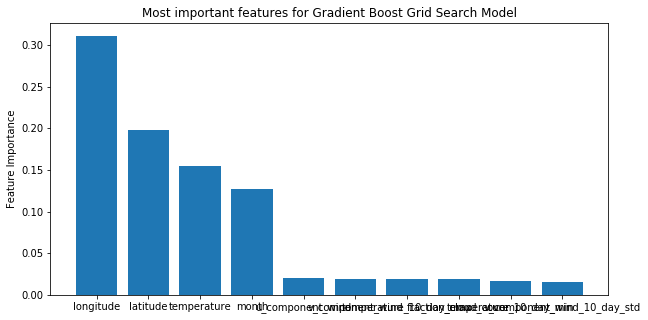

In [98]:
#plotting top 10 feature importance
fig=plt.figure(figsize=(10, 5))
plt.bar(feature_importances_GB.index[:10], feature_importances_GB['Importance'][:10])
plt.title("Most important features for Gradient Boost Grid Search Model")
plt.ylabel("Feature Importance")
plt.show()

In [99]:
#grabbing prediction probabilities
GB_prediction_probs = GS_gb_best.predict_proba(X_test_scaled)[:,1]

#looping through threshold levels for precision, recall, accuracy scores
thresh=np.arange(.05,1,.05)
GB_lst_recall = []
GB_lst_precision =[]
GB_lst_accuracy = []

for i in thresh:
    preds = [1 if x==True else 0 for x in GB_prediction_probs > i] #Gradientboost prediction probs
    report = classification_report(y_test, preds, zero_division=0, output_dict=True)
    GB_lst_recall.append(report['1']['recall'])
    GB_lst_precision.append(report['1']['precision'])
    GB_lst_accuracy.append(report['accuracy'])
    

df_GB = pd.DataFrame([GB_lst_recall, GB_lst_precision, GB_lst_accuracy,thresh], 
                     index=["Recall", "Precision","Accuracy","Threshold"]).T
df_GB

,Recall,Precision,Accuracy,Threshold
0,0.590456,0.098895,0.905991,0.05
1,0.296915,0.137831,0.958426,0.10
2,0.117090,0.174902,0.976695,0.15
3,0.033789,0.211296,0.982263,0.20
4,0.009032,0.225237,0.983405,0.25
5,0.004081,0.241935,0.983621,0.30
6,0.002231,0.226519,0.983675,0.35
7,0.001360,0.190840,0.983691,0.40
8,0.000707,0.164557,0.983716,0.45
9,0.000490,0.142857,0.983723,0.50


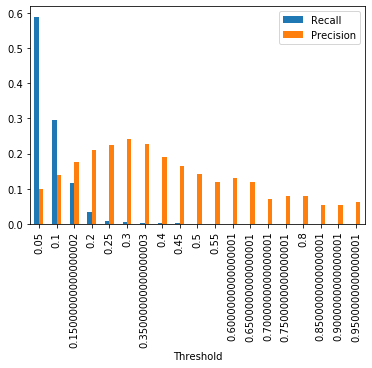

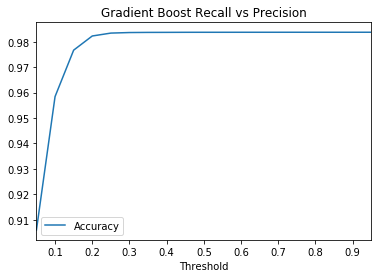

In [100]:
#plotting
df_GB.plot(x=3, y=[0,1], kind='bar')
df_GB.plot(x=3, y=2, kind='line')
plt.title("Gradient Boost Recall vs Precision")
plt.show()

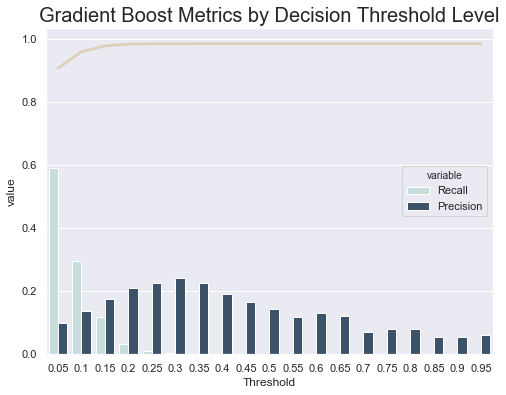

In [465]:
#melting recall, precision
df_GB_ploting = df_GB.melt(id_vars =['Threshold'], value_vars =['Recall', 'Precision'])
df_GB_ploting['Threshold'] = round(df_GB_ploting['Threshold'],2)
#df_AB_ploting.head(10)

#melting accuracy
df_GB_ploting2 = df_GB.melt(id_vars =['Threshold'], value_vars =['Accuracy'])
df_GB_ploting2['Threshold'] = round(df_GB_ploting2['Threshold'],2)
#df_AB_ploting2.head(10)

#best plot yet
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.barplot(x="Threshold", y="value", hue="variable", data=df_GB_ploting, palette="ch:2.9,-.2,dark=.3")
sns.pointplot(x='Threshold', y='value', data=df_GB_ploting2,ax=ax, color='#ded0b7', markers = "")
plt.title("Gradient Boost Metrics by Decision Threshold Level", fontsize=20)
plt.show()


# saving best threshold predictions

In [113]:
#saving optimized predictions
gb_preds_opt = [1 if x==True else 0 for x in GS_gb_best.predict_proba(X_test_scaled)[:,1] >= .15]
gb_preds_opt[:10]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

# Next Step: combine into ensemble:

In [114]:
Predictions = pd.DataFrame({'Gradient_Boost': gb_preds_opt, 
                            'Ada_Boost': ab_preds_opt, 
                            "Logistic_Regression": logreg_preds_opt,
                           "Random_Forest":RF_preds_opt } )

In [116]:
#adding sum column
Predictions['Sum']= Predictions.sum(axis=1)


In [129]:
#ensemble_1 : if 3 or 4 models predict severe weather
Predictions["Ensemble_1"]= [1 if x >2  else 0 for x in Predictions['Sum']]

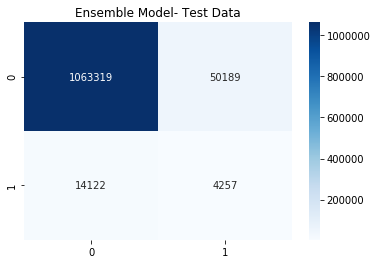

In [130]:
# Test data Confusion Matrix
cm = confusion_matrix(y_test,Predictions['Ensemble_1'])

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'Ensemble Model- Test Data')
plt.show()

In [131]:
# test data classification report
print('Ensemble Model- Test Data')
print(classification_report(y_test,Predictions['Ensemble_1'], zero_division=0))

Ensemble Model- Test Data
              precision    recall  f1-score   support

           0       0.99      0.95      0.97   1113508
           1       0.08      0.23      0.12     18379

    accuracy                           0.94   1131887
   macro avg       0.53      0.59      0.54   1131887
weighted avg       0.97      0.94      0.96   1131887



In [373]:
ensemble_report_rawdata = classification_report(y_test,Predictions['Ensemble_1'], zero_division=0, output_dict=True)
ensemble_report_rawdata['1']['precision']
ensemble_report_rawdata['1']['recall']

0.23162304804396322

# Now Moving on to undersampled data

### Logistic Regression on underampled & scaled data

In [140]:
#confirming value counts of train data
y_train_rus.value_counts()

1    42654
0    42654
Name: target, dtype: int64

In [142]:
#creating paramater grid
param_grid_logreg_rus = {
    'C':np.arange(.01, 2.02,1).tolist(),
    'random_state': [1],
    'max_iter': [1000]
}

#creating logistic regression object
logreg_clf_rus = LogisticRegression(random_state=1)

#initializing grid search object 
GS_logreg_grid_rus = GridSearchCV(logreg_clf_rus, param_grid_logreg_rus, cv=5, verbose=5, n_jobs=-1, scoring = 'roc_auc')

#fitting gridsearch on train data
GS_logreg_res_rus = GS_logreg_grid_rus.fit(X_train_rus_scaled,y_train_rus)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    3.8s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    4.1s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    4.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.8s finished


In [143]:
#fitting new model name to the best estimator
logreg_GS_best_rus = GS_logreg_res_rus.best_estimator_

#saving model with pickle
import pickle
filename = 'logreg_GS_best_rus_model.sav'
pickle.dump(logreg_GS_best_rus, open(filename, 'wb'))

# load the model from disk
logreg_res_rus = pickle.load(open('logreg_GS_best_rus_model.sav', 'rb'))

In [144]:
#making predictions on test data
GS_logreg_rus_test_pred = logreg_res_rus.predict(X_test_scaled)

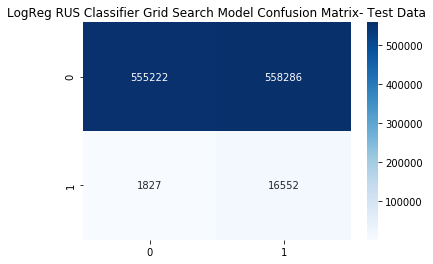

In [145]:
# Test data Confusion Matrix
cm = confusion_matrix(y_test, GS_logreg_rus_test_pred)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'LogReg RUS Classifier Grid Search Model Confusion Matrix- Test Data')
plt.show()

In [146]:
# test data classification report
print("GS RUS logreg on Test Data Classification Report:")
print(classification_report(y_test, GS_logreg_rus_test_pred, zero_division=0))

GS RUS logreg on Test Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.66   1113508
           1       0.03      0.90      0.06     18379

    accuracy                           0.51   1131887
   macro avg       0.51      0.70      0.36   1131887
weighted avg       0.98      0.51      0.65   1131887



In [147]:
#making predictions on training data
logreg_GS_rus_train_pred = logreg_res_rus.predict(X_train_rus_scaled)

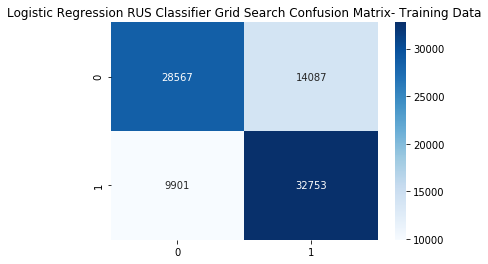

In [149]:
# Training data Confusion Matrix
cm = confusion_matrix(y_train_rus, logreg_GS_rus_train_pred)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'Logistic Regression RUS Classifier Grid Search Confusion Matrix- Training Data')
plt.show()

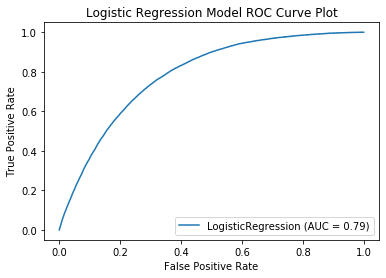

In [150]:
#Plotting AUC curve 
RF_disp = plot_roc_curve(logreg_res_rus, X_test_scaled, y_test)
plt.title("Logistic Regression Model ROC Curve Plot")
plt.show()

### Optimizing prediction threshold

In [151]:
#grabbing prediction probabilities
logreg_rus_prediction_probs = logreg_res_rus.predict_proba(X_test_scaled)[:,1]

In [152]:
#looping through threshold levels for precision, recall, accuracy scores
thresh=np.arange(.05,1,.05)
logreg_lst_rus_recall = []
logreg_lst_rus_precision =[]
logreg_lst_rus_accuracy = []

for i in thresh:
    logreg_rus_preds = [1 if x==True else 0 for x in logreg_rus_prediction_probs > i] #logistic regression RUS prediction probs
    report = classification_report(y_test, logreg_rus_preds, zero_division=0, output_dict=True)
    logreg_lst_rus_recall.append(report['1']['recall'])
    logreg_lst_rus_precision.append(report['1']['precision'])
    logreg_lst_rus_accuracy.append(report['accuracy'])

In [153]:
#grabbing results of loop in dataframe

df_logreg_rus = pd.DataFrame([logreg_lst_rus_recall, logreg_lst_rus_precision, logreg_lst_rus_accuracy,thresh], 
                     index=["Recall", "Precision","Accuracy","Threshold"]).T
df_logreg_rus

,Recall,Precision,Accuracy,Threshold
0,0.999728,0.016482,0.031311,0.05
1,0.998313,0.017044,0.065135,0.10
2,0.995865,0.017813,0.108299,0.15
3,0.991349,0.018790,0.159287,0.20
4,0.985037,0.019944,0.213787,0.25
5,0.976495,0.021284,0.270527,0.30
6,0.964797,0.022812,0.328347,0.35
7,0.950269,0.024571,0.386642,0.40
8,0.929594,0.026566,0.445768,0.45
9,0.900593,0.028794,0.505151,0.50


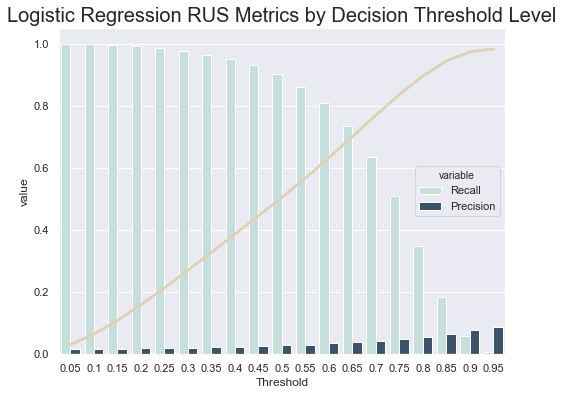

In [477]:
#melting recall, precision
df_logreg_rus_ploting = df_logreg_rus.melt(id_vars =['Threshold'], value_vars =['Recall', 'Precision'])
df_logreg_rus_ploting['Threshold'] = round(df_logreg_rus_ploting['Threshold'],2)
#df_AB_ploting.head(10)

#melting accuracy
df_logreg_rus_ploting2 = df_logreg_rus.melt(id_vars =['Threshold'], value_vars =['Accuracy'])
df_logreg_rus_ploting2['Threshold'] = round(df_logreg_rus_ploting2['Threshold'],2)
#df_AB_ploting2.head(10)

#best plot yet
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.barplot(x="Threshold", y="value", hue="variable", data=df_logreg_rus_ploting, palette="ch:2.9,-.2,dark=.3")
sns.pointplot(x='Threshold', y='value', data=df_logreg_rus_ploting2,ax=ax, color='#ded0b7', markers = "")
plt.title("Logistic Regression RUS Metrics by Decision Threshold Level",fontsize=20)
plt.show()

In [155]:
#saving optimized predictions
logreg_rus_preds_opt = [1 if x==True else 0 for x in logreg_res.predict_proba(X_test_scaled)[:,1] >= .75]
logreg_rus_preds_opt[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Random Forest- RUS

In [156]:
#creating model object
RF_clf_rus = RandomForestClassifier(random_state=1, verbose=5, n_jobs=-1)

#creating paramater grid
param_grid_RF_rus = {
    'n_estimators':np.arange(50, 170,10).tolist(),
    'random_state': [1],
    'max_depth': np.arange(4,15,2).tolist()
 }

#creating gridseatrc
GS_RF_rus_grid = GridSearchCV(RF_clf_rus, param_grid_RF_rus, cv=5, verbose=1, n_jobs=-1, scoring = 'roc_auc')

#fitting gridsearch on train data
GS_RF_res_rus = GS_RF_rus_grid.fit(X_train_rus,y_train_rus)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.8s
/Users/markroberts/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 20.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150building tree 12 of 150

building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
b

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.5s


building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150building tree 80 of 150
building tree 81 of 150

building tree 82 of 150
building tree 83 of 150
building tree 84 of 150
building tree 85 of 150
building tree 86 of 150building tree 87 of 150

building tree 88 of 150
building tree 89 of 150
building tree 90 of 150building tree 91 of 150

building tree 92 of 150
building tree 93 of 150
building tree 94 of 150
building tree 95 of 150
building tree 96 of 150
building tree 97 of 150
building tree 98 of 150
building tree 99 of 150
building tree 100 of 150
building tree 101 of 150
building tree 

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    8.3s finished


In [159]:
#fitting new model to the best estimator with best parameters
RF_rus_GS_best = GS_RF_res_rus.best_estimator_
RF_rus_GS_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=5,
                       warm_start=False)

In [160]:
#saving model
import pickle
filename = 'RF_rus_GS_best_model.sav'
pickle.dump(RF_rus_GS_best, open(filename, 'wb'))

# load the model from disk
RF_rus_GS_best = pickle.load(open('RF_rus_GS_best_model.sav', 'rb'))

In [161]:
#making test predictions using test data
GS_RF_test_pred_rus = RF_rus_GS_best.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    4.0s finished


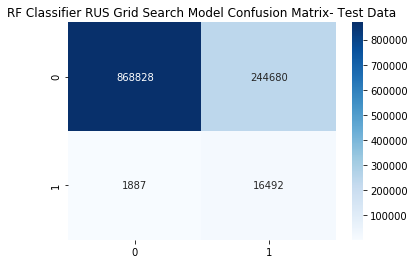

In [162]:
# Test data Confusion Matrix
cm = confusion_matrix(y_test, GS_RF_test_pred_rus)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'RF Classifier RUS Grid Search Model Confusion Matrix- Test Data')
plt.show()

In [163]:
# test data classification report
print("GS RF Classifier RUS on Test Data Classification Report:")
print(classification_report(y_test, GS_RF_test_pred, zero_division=0))

GS RF Classifier RUS on Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1113508
           1       0.00      0.00      0.00     18379

    accuracy                           0.98   1131887
   macro avg       0.49      0.50      0.50   1131887
weighted avg       0.97      0.98      0.98   1131887



### Checking training data performance

In [164]:
#making predictions on training data
RF_train_pred_rus = RF_rus_GS_best.predict(X_train_rus)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.3s finished


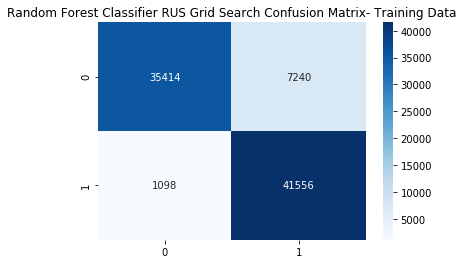

In [165]:
# Train data Confusion Matrix
cm = confusion_matrix(y_train_rus, RF_train_pred_rus)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'Random Forest Classifier RUS Grid Search Confusion Matrix- Training Data')
plt.show()

In [166]:
# train data classification report
print("Random Forest Classifier RUS Grid Search on Train Data Classification Report:")
print(classification_report(y_train_rus, RF_train_pred_rus, zero_division=0))

Random Forest Classifier RUS Grid Search on Train Data Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     42654
           1       0.85      0.97      0.91     42654

    accuracy                           0.90     85308
   macro avg       0.91      0.90      0.90     85308
weighted avg       0.91      0.90      0.90     85308



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    3.8s finished


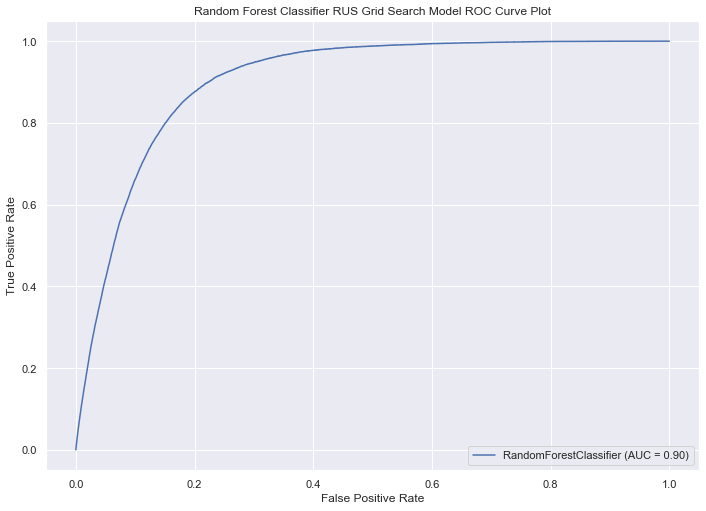

In [478]:
#Plotting AUC 
plot_roc_curve(RF_rus_GS_best, X_test, y_test)
plt.title("Random Forest Classifier RUS Grid Search Model ROC Curve Plot")
plt.show()

# Optimizing Prediction Threshold- RF RUS

In [168]:
#grabbing prediction probabilities
RF_prediction_probs_rus = RF_rus_GS_best.predict_proba(X_test)[:,1]

#looping through threshold levels for precision, recall, accuracy scores
thresh=np.arange(.05,1,.05)
RF_rus_lst_recall = []
RF_rus_lst_precision =[]
RF_rus_lst_accuracy = []

for i in thresh:
    preds = [1 if x==True else 0 for x in RF_prediction_probs_rus > i] #Random Forest RUS prediction probs
    report = classification_report(y_test, preds, zero_division=0, output_dict=True)
    RF_rus_lst_recall.append(report['1']['recall'])
    RF_rus_lst_precision.append(report['1']['precision'])
    RF_rus_lst_accuracy.append(report['accuracy'])
    

df_RF_rus = pd.DataFrame([RF_rus_lst_recall, RF_rus_lst_precision, RF_rus_lst_accuracy,thresh], 
                     index=["Recall", "Precision","Accuracy","Threshold"]).T
df_RF_rus


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    3.6s finished


,Recall,Precision,Accuracy,Threshold
0,0.999456,0.018880,0.156637,0.05
1,0.997715,0.022143,0.284534,0.10
2,0.994233,0.026331,0.402939,0.15
3,0.988683,0.031023,0.498386,0.20
4,0.982045,0.035973,0.572381,0.25
5,0.972795,0.041008,0.630164,0.30
6,0.958703,0.046028,0.676689,0.35
7,0.942870,0.051370,0.716352,0.40
8,0.922738,0.057019,0.750957,0.45
9,0.897328,0.063146,0.782163,0.50


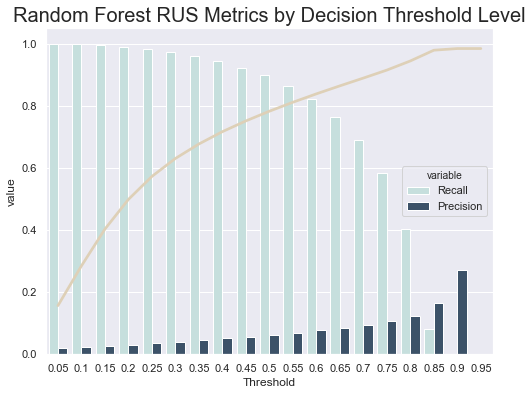

In [455]:
#melting recall, precision
df_RF_rus_ploting = df_RF_rus.melt(id_vars =['Threshold'], value_vars =['Recall', 'Precision'])
df_RF_rus_ploting['Threshold'] = round(df_RF_rus_ploting['Threshold'],2)

#melting accuracy
df_RF_rus_ploting2 = df_RF_rus.melt(id_vars =['Threshold'], value_vars =['Accuracy'])
df_RF_rus_ploting2['Threshold'] = round(df_RF_rus_ploting2['Threshold'],2)

#best plot yet
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.barplot(x="Threshold", y="value", hue="variable", data=df_RF_rus_ploting, palette="ch:2.9,-.2,dark=.3")
sns.pointplot(x='Threshold', y='value', data=df_RF_rus_ploting2,ax=ax, color="#ded0b7", markers = "")
plt.title("Random Forest RUS Metrics by Decision Threshold Level", fontsize=20)
plt.show()

In [170]:
#saving optimized predictions
RF_rus_preds_opt = [1 if x==True else 0 for x in RF_rus_GS_best.predict_proba(X_test)[:,1] >= .75] #precision = .107, recall = .584
RF_rus_preds_opt[:10]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    3.6s finished


[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

In [480]:
#melting recall, precision, accuracy
df_RF_rus_tableau = df_RF_rus.melt(id_vars =['Threshold'], value_vars =['Recall', 'Precision', 'Accuracy'])
df_RF_rus_tableau['Threshold'] = round(df_RF_rus_tableau['Threshold'],2)

#saving to csv for tableau plot
df_RF_rus_tableau.to_csv("RF_rus_melted.csv")

#saving original df to csv
df_RF_rus.to_csv("RF_rus_melted_full.csv")

# ADABoost Random Undersampled

In [171]:
#initilizing
ABC_GS_rus = AdaBoostClassifier()

#creating paramater grid
param_grid_ab_rus = {
    'n_estimators':np.arange(50, 110, 10).tolist(), #additional
    'learning_rate': [.1,.5,.75,1,1.5,2], #additional
    'random_state': [1]
 }

#initializing grid search object 
GS_ab_rus = GridSearchCV(ABC_GS_rus,param_grid_ab_rus, cv=5, verbose=5, n_jobs=-1, scoring = 'roc_auc')

#fitting gridsearch on train data
GS_ab_rus_res = GS_ab_rus.fit(X_train_rus_scaled,y_train_rus)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.7min finished


In [172]:
#grabbing best estimator
GS_ab_rus_best = GS_ab_rus_res.best_estimator_
GS_ab_rus_best

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=100, random_state=1)

In [173]:
#saving model
import pickle
filename = 'GS_ab_rus_best_model.sav'
pickle.dump(GS_ab_rus_best, open(filename, 'wb'))

# load the model from disk
GS_ab_rus_best = pickle.load(open('GS_ab_rus_best_model.sav', 'rb'))

In [176]:
#making test predictions
GS_ab_best_test_pred_rus = GS_ab_rus_best.predict(X_test_scaled)


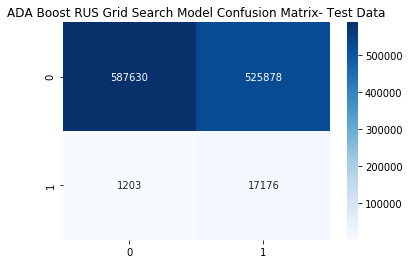

In [177]:
# Test data Confusion Matrix
cm = confusion_matrix(y_test,GS_ab_best_test_pred_rus)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'ADA Boost RUS Grid Search Model Confusion Matrix- Test Data')
plt.show()

In [178]:
# test data classification report
print('ADA Boost GS RUS Model Confusion Matrix- Test Data')
print(classification_report(y_test,GS_ab_best_test_pred_rus , zero_division=0))

ADA Boost GS RUS Model Confusion Matrix- Test Data
              precision    recall  f1-score   support

           0       1.00      0.53      0.69   1113508
           1       0.03      0.93      0.06     18379

    accuracy                           0.53   1131887
   macro avg       0.51      0.73      0.38   1131887
weighted avg       0.98      0.53      0.68   1131887



In [180]:
#making predictions on training data
GS_ab_best_train_pred_rus = GS_ab_rus_best.predict(X_train_rus_scaled)

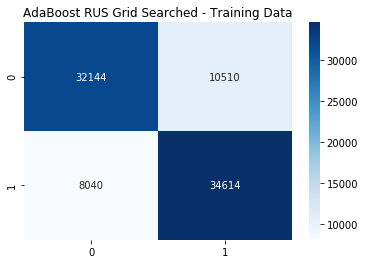

In [182]:
# Training data Confusion Matrix
cm = confusion_matrix(y_train_rus,GS_ab_best_train_pred_rus)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'AdaBoost RUS Grid Searched - Training Data')
plt.show()

In [183]:
# training data classification report
print("AdaBoost RUS GS Training Data Classification Report:")
print(classification_report(y_train_rus, GS_ab_best_train_pred_rus, zero_division=0))

AdaBoost RUS GS Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78     42654
           1       0.77      0.81      0.79     42654

    accuracy                           0.78     85308
   macro avg       0.78      0.78      0.78     85308
weighted avg       0.78      0.78      0.78     85308



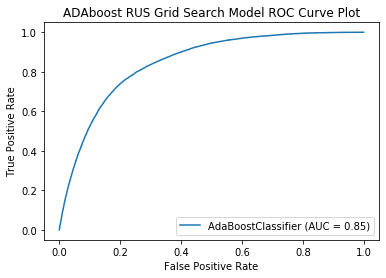

In [186]:
#Plotting AUC 
plot_roc_curve(GS_ab_rus_best, X_test_scaled, y_test)
plt.title("ADAboost RUS Grid Search Model ROC Curve Plot")
plt.show()

In [188]:
#grabbing prediction probabilities
AB_prediction_probs_rus = GS_ab_rus_best.predict_proba(X_test_scaled)[:,1]

#looping through threshold levels for precision, recall, accuracy scores
thresh=np.arange(.05,1,.05)
AB_rus_lst_recall = []
AB_rus_lst_precision =[]
AB_rus_lst_accuracy = []

for i in thresh:
    preds = [1 if x==True else 0 for x in AB_prediction_probs_rus > i] #ADAboost prediction probs
    report = classification_report(y_test, preds, zero_division=0, output_dict=True)
    AB_rus_lst_recall.append(report['1']['recall'])
    AB_rus_lst_precision.append(report['1']['precision'])
    AB_rus_lst_accuracy.append(report['accuracy'])
    

df_AB_rus = pd.DataFrame([AB_rus_lst_recall, AB_rus_lst_precision, AB_rus_lst_accuracy,thresh], 
                     index=["Recall", "Precision","Accuracy","Threshold"]).T
df_AB_rus

,Recall,Precision,Accuracy,Threshold
0,1.000000,0.016237,0.016237,0.05
1,1.000000,0.016237,0.016237,0.10
2,1.000000,0.016237,0.016237,0.15
3,1.000000,0.016237,0.016237,0.20
4,1.000000,0.016237,0.016237,0.25
5,1.000000,0.016237,0.016237,0.30
6,1.000000,0.016237,0.016237,0.35
7,1.000000,0.016265,0.017915,0.40
8,1.000000,0.016268,0.018111,0.45
9,0.934545,0.031629,0.534334,0.50


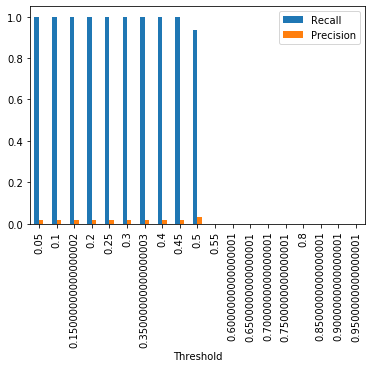

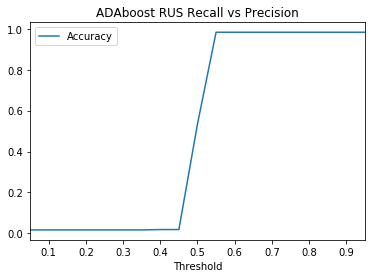

In [189]:
#plotting
df_AB_rus.plot(x=3, y=[0,1], kind='bar')
df_AB_rus.plot(x=3, y=2, kind='line')
plt.title("ADAboost RUS Recall vs Precision")
plt.show()

### Zooming in on ~48-51 threshold

In [202]:
#printing max proba
max(GS_ab_rus_best.predict_proba(X_test_scaled)[:,1])

0.5187552278451687

In [203]:
#printing min proba
min(GS_ab_rus_best.predict_proba(X_test_scaled)[:,1])

0.37196520595828825

In [211]:
# rerunning threshold loop

#grabbing prediction probabilities
AB_prediction_probs_rus = GS_ab_rus_best.predict_proba(X_test_scaled)[:,1]

#looping through threshold levels for precision, recall, accuracy scores
thresh_new =np.arange(.48,.52,.001) #updated threshold
AB_rus_lst_recall = []
AB_rus_lst_precision =[]
AB_rus_lst_accuracy = []

for i in thresh_new:
    preds = [1 if x==True else 0 for x in AB_prediction_probs_rus > i] #ADAboost prediction probs
    report = classification_report(y_test, preds, zero_division=0, output_dict=True)
    AB_rus_lst_recall.append(report['1']['recall'])
    AB_rus_lst_precision.append(report['1']['precision'])
    AB_rus_lst_accuracy.append(report['accuracy'])
    

df_AB_rus = pd.DataFrame([AB_rus_lst_recall, AB_rus_lst_precision, AB_rus_lst_accuracy,thresh_new], 
                     index=["Recall", "Precision","Accuracy","Threshold"]).T
df_AB_rus

,Recall,Precision,Accuracy,Threshold
0,1.000000,0.016402,0.026282,0.480
1,1.000000,0.016463,0.029956,0.481
2,0.999946,0.016545,0.034852,0.482
3,0.999782,0.016644,0.040887,0.483
4,0.999782,0.016769,0.048152,0.484
5,0.999728,0.016935,0.057683,0.485
6,0.999565,0.017143,0.069478,0.486
7,0.999401,0.017393,0.083232,0.487
8,0.999075,0.017694,0.099360,0.488
9,0.998531,0.018061,0.118478,0.489


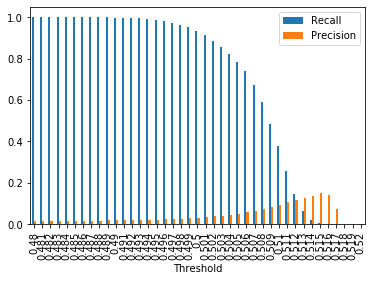

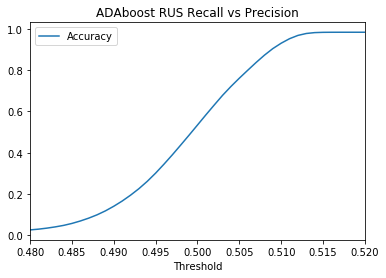

In [213]:
#plotting
df_AB_rus.plot(x=3, y=[0,1], kind='bar')
df_AB_rus.plot(x=3, y=2, kind='line')
plt.title("ADAboost RUS Recall vs Precision")
plt.show()

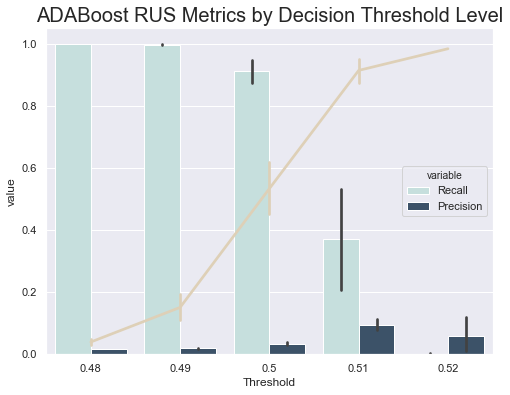

In [453]:
#melting recall, precision
df_AB_rus_ploting = df_AB_rus.melt(id_vars =['Threshold'], value_vars =['Recall', 'Precision'])
df_AB_rus_ploting['Threshold'] = round(df_AB_rus_ploting['Threshold'],2)

#melting accuracy
df_AB_rus_ploting2 = df_AB_rus.melt(id_vars =['Threshold'], value_vars =['Accuracy'])
df_AB_rus_ploting2['Threshold'] = round(df_AB_rus_ploting2['Threshold'],2)

#best plot yet
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.barplot(x="Threshold", y="value", hue="variable", data=df_AB_rus_ploting, palette="ch:2.9,-.2,dark=.3")
sns.pointplot(x='Threshold', y='value', data=df_AB_rus_ploting2,ax=ax, color="#ded0b7", markers = "")
plt.title("ADABoost RUS Metrics by Decision Threshold Level",fontsize=20)
plt.show()

In [214]:
#saving optimized predictions
ab_rus_preds_opt = [1 if x==True else 0 for x in GS_ab_rus_best.predict_proba(X_test_scaled)[:,1] >= .511] #grabbed from above table and graphs
ab_rus_preds_opt[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Gradient Boost RUS

In [215]:
# Initializing object
GB_GS_rus = GradientBoostingClassifier()

#creating paramater grid
param_grid_gb_rus = {
    'n_estimators':np.arange(50, 110, 10).tolist(), #increased
    'learning_rate': [.1,.25,.5,.75,1,1.5,2], #increased
    'random_state': [1]
 }

#initializing grid search object 
GS_gb_rus = GridSearchCV(GB_GS_rus,param_grid_ab_rus, cv=5, verbose=5, n_jobs=-1, scoring = 'roc_auc')

#fitting gridsearch on train data
GS_gb_rus = GS_gb_rus.fit(X_train_rus_scaled,y_train_rus)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 22.0min finished


In [216]:
#best estimator
GS_rus_gb_best = GS_gb_rus.best_estimator_
GS_rus_gb_best

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [217]:
#saving model
import pickle
filename = 'GS_rus_gb_best_model.sav'
pickle.dump(GS_rus_gb_best, open(filename, 'wb'))

# load the model from disk
GS_rus_gb_best = pickle.load(open('GS_rus_gb_best_model.sav', 'rb'))

In [220]:
#test predictions
GS_gb_best_test_pred_rus = GS_rus_gb_best.predict(X_test_scaled)

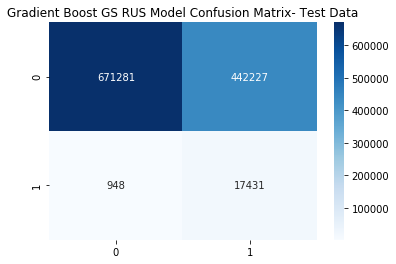

In [221]:
# Test data Confusion Matrix
cm = confusion_matrix(y_test,GS_gb_best_test_pred_rus)

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'Gradient Boost GS RUS Model Confusion Matrix- Test Data')
plt.show()

In [222]:
# test data classification report
print('Gradient Boost GS RUS Model Confusion Matrix- Test Data')
print(classification_report(y_test,GS_gb_best_test_pred_rus , zero_division=0))

Gradient Boost GS RUS Model Confusion Matrix- Test Data
              precision    recall  f1-score   support

           0       1.00      0.60      0.75   1113508
           1       0.04      0.95      0.07     18379

    accuracy                           0.61   1131887
   macro avg       0.52      0.78      0.41   1131887
weighted avg       0.98      0.61      0.74   1131887



In [224]:
#making predictions on training data
GS_gb_best_train_pred_rus = GS_rus_gb_best.predict(X_train_scaled)

In [225]:
# training data classification report
print("AdaBoost GS RUS Training Data Classification Report:")
print(classification_report(y_train, GS_gb_best_train_pred_rus, zero_division=0))

AdaBoost GS RUS Training Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75   2598413
           1       0.04      0.95      0.07     42654

    accuracy                           0.61   2641067
   macro avg       0.52      0.78      0.41   2641067
weighted avg       0.98      0.61      0.74   2641067



In [226]:
#grabbing prediction probabilities
GB_prediction_probs_rus = GS_rus_gb_best.predict_proba(X_test_scaled)[:,1]

#looping through threshold levels for precision, recall, accuracy scores
thresh=np.arange(.05,1,.05)
GB_rus_lst_recall = []
GB_rus_lst_precision =[]
GB_rus_lst_accuracy = []

for i in thresh:
    preds = [1 if x==True else 0 for x in GB_prediction_probs_rus > i] #Gradientboost prediction probs
    report = classification_report(y_test, preds, zero_division=0, output_dict=True)
    GB_rus_lst_recall.append(report['1']['recall'])
    GB_rus_lst_precision.append(report['1']['precision'])
    GB_rus_lst_accuracy.append(report['accuracy'])
    

df_GB_rus = pd.DataFrame([GB_rus_lst_recall, GB_rus_lst_precision, GB_rus_lst_accuracy,thresh], 
                     index=["Recall", "Precision","Accuracy","Threshold"]).T
df_GB_rus

,Recall,Precision,Accuracy,Threshold
0,0.999184,0.019579,0.187565,0.05
1,0.997062,0.021768,0.272388,0.10
2,0.994069,0.023655,0.333673,0.15
3,0.990587,0.025455,0.384058,0.20
4,0.986343,0.027220,0.427404,0.25
5,0.981120,0.029030,0.466855,0.30
6,0.974373,0.030913,0.503610,0.35
7,0.966973,0.032962,0.538826,0.40
8,0.959301,0.035305,0.573720,0.45
9,0.948419,0.037922,0.608464,0.50


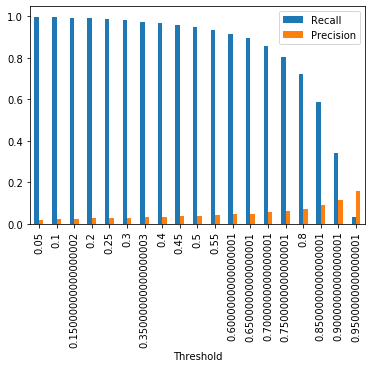

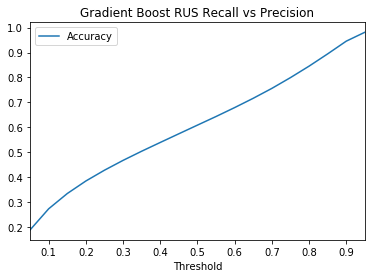

In [227]:
#plotting
df_GB_rus.plot(x=3, y=[0,1], kind='bar')
df_GB_rus.plot(x=3, y=2, kind='line')
plt.title("Gradient Boost RUS Recall vs Precision")
plt.show()

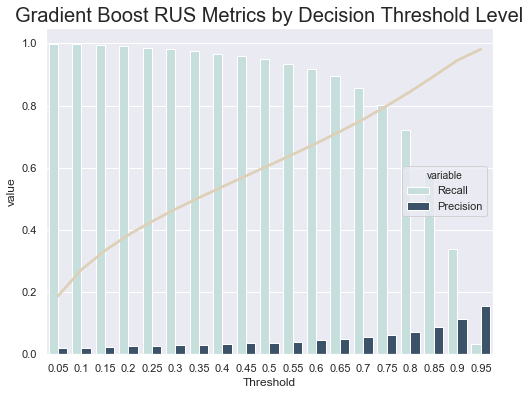

In [446]:
#melting recall, precision
df_GB_rus_ploting = df_GB_rus.melt(id_vars =['Threshold'], value_vars =['Recall', 'Precision'])
df_GB_rus_ploting['Threshold'] = round(df_GB_rus_ploting['Threshold'],2)

#melting accuracy
df_GB_rus_ploting2 = df_GB_rus.melt(id_vars =['Threshold'], value_vars =['Accuracy'])
df_GB_rus_ploting2['Threshold'] = round(df_GB_rus_ploting2['Threshold'],2)

#best plot yet
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.barplot(x="Threshold", y="value", hue="variable", data=df_GB_rus_ploting, palette="ch:2.9,-.2,dark=.3")
sns.pointplot(x='Threshold', y='value', data=df_GB_rus_ploting2,ax=ax, color="#ded0b7" , markers = "")
plt.title("Gradient Boost RUS Metrics by Decision Threshold Level", fontsize=20)
plt.show()

In [230]:
#saving optimized predictions
gb_rus_preds_opt = [1 if x==True else 0 for x in GS_rus_gb_best.predict_proba(X_test_scaled)[:,1] >= .85] #precision  
gb_rus_preds_opt[:10]

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

# RUS Ensemble

In [231]:
Predictions_RUS = pd.DataFrame({'Gradient_Boost': gb_preds_opt_rus, 
                            'Ada_Boost': ab_rus_preds_opt, 
                            "Logistic_Regression": logreg_rus_preds_opt,
                           "Random_Forest":RF_rus_preds_opt } )

In [232]:
#adding sum column
Predictions_RUS['Sum']= Predictions_RUS.sum(axis=1)

In [242]:
#ensemble_1 : if 2 or more models predict severe weather
Predictions_RUS["Ensemble_1"]= [1 if x >1  else 0 for x in Predictions_RUS['Sum']]

In [369]:
Predictions_RUS

,Gradient_Boost,Ada_Boost,Logistic_Regression,Random_Forest,Sum,Ensemble_1
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
1131882,1,1,0,1,3,1
1131883,0,0,0,0,0,0
1131884,1,0,0,0,1,0
1131885,0,0,0,0,0,0


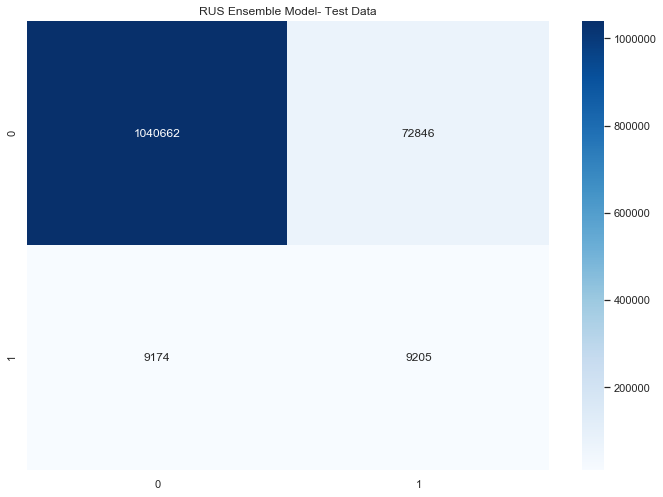

In [448]:
# Test data Confusion Matrix
cm = confusion_matrix(y_test,Predictions_RUS['Ensemble_1'])

#plotting heatmap confusion matrix
sns.heatmap(cm, annot=True, 
                cmap='Blues',fmt="d").set_title(
    'RUS Ensemble Model- Test Data')
plt.show()

In [377]:
# test data classification report
print('RUS Ensemble Model- Test Data')
print(classification_report(y_test,Predictions_RUS['Ensemble_1'], zero_division=0))


RUS Ensemble Model- Test Data
              precision    recall  f1-score   support

           0       0.99      0.93      0.96   1113508
           1       0.11      0.50      0.18     18379

    accuracy                           0.93   1131887
   macro avg       0.55      0.72      0.57   1131887
weighted avg       0.98      0.93      0.95   1131887



In [378]:
ensemble_report_rus = classification_report(y_test,Predictions_RUS['Ensemble_1'], zero_division=0, output_dict=True)
ensemble_report_rus['1']['precision']
ensemble_report_rus['1']['recall']

0.5008433538277381

# Precision improvement of 37.5% (.08 to .11)
# Recall lift of 117% (.23 to .50)

In [388]:
d = {'Value': [ensemble_report_rawdata['1']['precision'],
                ensemble_report_rawdata['1']['recall'],
                ensemble_report_rus['1']['precision'],
                 ensemble_report_rus['1']['recall']],
     'Metric': ['Precision', 'Recall','Precision','Recall'],
    'Type': ["Raw", "Raw", "RUS", "RUS"]}

final_output_df = pd.DataFrame(data=d)

In [389]:
final_output_df

,Value,Metric,Type
0,0.078188,Precision,Raw
1,0.231623,Recall,Raw
2,0.112186,Precision,RUS
3,0.500843,Recall,RUS


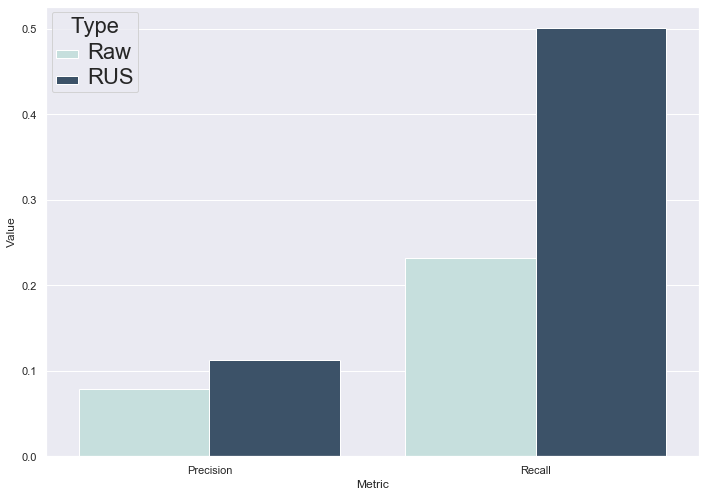

In [485]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="Metric", y="Value", hue="Type", data=final_output_df, palette="ch:2.9,-.2,dark=.3")
#plt.title("Ensemble Results: Raw data vs Random Undersampled", fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22') # for legend title
plt.show()